# Tractography pipeline for neuronal fibers
This notebook take a 3d volume of images and returns the detected axons

## Importing dependencies

In [2]:
from bossHandler import bossHandler
from tractography import vertices
from intern.resource.boss.resource import *
from intern.remote.boss import BossRemote
from skimage import filters
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.mlab as mlab
import glob
import skfmm
from scipy.ndimage.filters import laplace
from skimage.morphology import binary_opening, binary_closing, binary_dilation
from skimage.morphology import skeletonize_3d,label
from scipy.ndimage.morphology import *
from tifffile import imsave


## Download data from Boss
The bossHandler class uses Intern to connect to Boss and download volumes. If the tiff files are already downloaded (using ndpull), use the following cell to load from disk

In [ ]:
# Parameters:
coll_name = 'ailey-dev'
exp_name = 'DRN-BLA_2378'
chan_name = 'Ch0'
x_rng = [348, 500]
y_rng = [678, 878]
z_rng = [coor.z_start, coor.z_stop]

# Using bossHandler class to download from Boss:
bHandler = bossHandler(coll_name)
bHandler.select_experiment(exp_name)
exp = bHandler.get_experiment()
bHandler.list_channels()
bHandler.select_channel(chan_name)
coor = bHandler.get_coordinate_frame()
data_cutout_raw = bHandler.get_cutout(x_rng, y_rng, z_rng)
data_cutout_raw = data_cutout.astype('uint16')

## Load input data from disk
Currently the data is loaded from disk. It can also be downloaded from Boss using bossHandler or ndpull

In [8]:
# x_range = [9750, 10250]
# y_range = [18000, 18500]
# z_range = [500, 600]
tifPath = '/run/mount/DRN-BLA_2378_2p_glycerol_Ch0/test_0/*.tif'
tifList = sorted(glob.glob(tifPath))
if tifList: # check if not empty
    im_slice = plt.imread(tifList[0])
    data_cutout_raw = im_slice
        
    if len(tifList)>1: # check if more than 1 file
        for tifFile in tifList[1:]:
            im_slice = plt.imread(tifFile)
            data_cutout_raw = np.dstack((data_cutout_raw, im_slice))

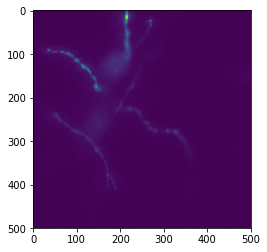

In [61]:
plt.imshow(data_cutout_raw[:,:,50])

## Binarization
Binarization is performed slice by slice using 4 component GMM. The cluster with the highest mean is picked as the binarized point set.

In [10]:
gmm_nc = 4
data_cutout_binarized = np.copy(data_cutout_raw)
vol_size = data_cutout_raw.shape
for i in np.arange(0 , vol_size[2]):
    data_slice = data_cutout_binarized[:,:,i]
    uniq = np.unique(data_slice , return_counts=True)
    
    gmm = GaussianMixture(gmm_nc, covariance_type = 'full').fit(data_slice.reshape(-1,1))
    cluster_labels = gmm.predict(data_slice.reshape(-1,1))
    cluster_labels = cluster_labels.reshape(data_slice.shape)
    x = np.arange(0,uniq[1].shape[0])
    c_id = np.argmax(gmm.means_) # index of the cluster with highest mean
    
    data_slice[cluster_labels == c_id] = 1
    data_slice[cluster_labels != c_id] = 0
    data_cutout_binarized[:,:,i] = data_slice

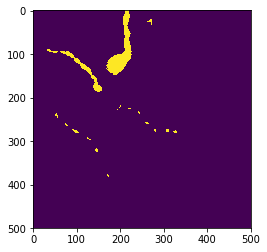

In [62]:
plt.imshow(data_cutout_binarized[:,:,50])

## Binary opening (erosion followed by dilation)
To further denoise the volume

In [13]:
data_cutout_binarized = binary_opening(data_cutout_binarized)

## Extract voxel weights
Extracted weights are an average of normalized intensity, normalized distance from boundary, and normalized laplacian

In [49]:
ttt = vertices(data_cutout_binarized , data_cutout_raw)
vw = ttt.compute_vertex_wight()

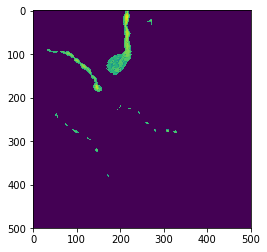

In [63]:
plt.imshow(vw[:,:,50])

## Visualize (animated)
Visualize as an animation iterating through z slices

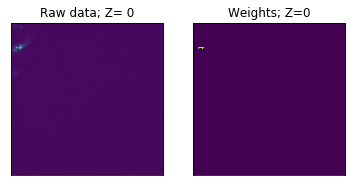

In [37]:
# Visualize the output (animation)

from matplotlib import animation
from IPython.display import HTML

z_rng = [0 , data_cutout_raw.shape[2]]
# z_rng = [70,80]
fig, (im1, im2) = plt.subplots(1, 2)

# fig.set_facecolor('black')
ax1 = im1.imshow(data_cutout_raw[:,:,0], animated=True)
ax2 = im2.imshow(vw[:,:,0], animated=True)

im1.get_xaxis().set_visible(False)
im2.get_xaxis().set_visible(False)

im1.get_yaxis().set_visible(False)
im2.get_yaxis().set_visible(False)

im1.set_title('Raw data')
im2.set_title('Weights')

def animate(i):
    ax1.set_data(data_cutout_raw[:,:,i])
    im1.set_title('Raw data; Z= ' + str(i))
#     ax1.set_cmap('gray')
    ax1.autoscale()
    
    ax2.set_data(vw[:,:,i])
    im2.set_title('Weights; Z=' + str(i))
#     ax2.set_cmap('gray')
    ax2.autoscale()
    return ax1

anim = animation.FuncAnimation(fig, animate, frames = np.arange(z_rng[0],z_rng[1]), interval = 50)
HTML(anim.to_jshtml())


## Skeletonize and extract connected components
Each connencted component is labeled with a unique colormap.
Outout - concomp_col: 

In [52]:
skeleton = skeletonize_3d(vw)
concomp = label(np.copy(skeleton) , connectivity=3)
cmap = plt.cm.get_cmap('nipy_spectral' , np.unique(concomp).size)

concomp_col = np.empty(concomp.shape + (3,), dtype = 'uint8')
for col in np.arange(np.unique(concomp).size):
    tmp = cmap(col)[0:-1]
    tmp = tuple(i*255 for i in tmp)
    concomp_col[concomp == col] = tmp

## Ingest to Boss
Upload the results back to Boss

In [ ]:
# Helper functions for ingestation (C: vikram)
def get_channel_resource(rmt, chan_name, coll_name, exp_name, type='image', base_resolution=0, sources=[], datatype='uint16', new_channel=True):
    channel_resource = ChannelResource(chan_name, coll_name, exp_name, type=type, 
                                    base_resolution=base_resolution, sources=sources, datatype=datatype)
    if new_channel: 

        new_rsc = rmt.create_project(channel_resource)
        return new_rsc

    return channel_resource



def upload_to_boss(rmt, data, channel_resource, resolution=0):
    Z_LOC = 0
    size = data.shape
    for i in range(0, data.shape[Z_LOC], 16):
        last_z = i+16
        if last_z > data.shape[Z_LOC]:
            last_z = data.shape[Z_LOC]
        print(resolution, [0, size[2]], [0, size[1]], [i, last_z])
        rmt.create_cutout(channel_resource, resolution, [0, size[2]], [0, size[1]], [i, last_z], np.asarray(data[i:last_z,:,:], order='C'))
        
        
# Ingest the results back to Boss
rmt = BossRemote()
new_coll_name = 'tractography'
new_exp_name = 'mvpsprint3'
new_chan_name = 'annot0'
create_new_channel = False

if create_new_channel:
    # new channel
    new_chan_resource = get_channel_resource(rmt, new_chan_name, new_coll_name, new_exp_name , new_channel=True)
    upload_to_boss(rmt, concomp, new_chan_resource)
    
else:
    # get existing channel
    chan_resource = rmt.get_channel(chan_name= new_chan_name, coll_name=new_coll_name, exp_name=new_exp_name)
    upload_to_boss(rmt, concomp, chan_resource)


## Save to disk as a tiff volume

In [56]:
imsave('./output_data/test_0_con_comp.tiff' , concomp_col)

imsave('./output_data/test_0_raw_2.tiff' , data_cutout_raw)